In [4]:
import correlation, glob, os
import correlation_steps as corrsteps
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm, mode

drive_file = "/data/20170622/bead4_15um_QWP/arb_charge/auto_xyzcool_G100_att_synth1000mV41Hz0mVdc.h5"
calibration_path = "/data/20170717/bead15_15um_QWP/calibration/"
measurement_path = "/data/20170717/bead15_15um_QWP/steps/measurement_3/"

In [5]:
calibration_list = glob.glob(os.path.join(calibration_path + "*.h5"))
N = float(len(calibration_list))
phase_array, corr = ([] for i in range(2))
#print "finding phase shift"
for f in calibration_list:
    #print f
    x_data, drive_data = corrsteps.getData(f, calib=True)
    # measure the correlation for normalization purposes
    corr_array = np.correlate(x_data, drive_data)
    # here we average the drive and correlation arrays
    if corr == []:
        corr = corr_array / N
    else:
        corr += corr_array / N
    # index of largest correlation coefficient
    phase_array.append(np.argmax(corr_array))
m, c = mode(phase_array)
index = int(m[0])
print "phase shift is ", index
c = corr[index] * 2 * correlation.num_electrons_in_sphere  # V^2/electron
print "calibrating constant c = ", c

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


phase shift is  106
calibrating constant c =  3.6788585434e+12


In [6]:
x_data, drive_data = corrsteps.getData(drive_file, calib=True)

corr, dc, t = ([] for i in range(3))
for f in glob.glob(os.path.join(measurement_path, "*.h5")):
    x_data, bgDC, time = corrsteps.getData(f)
    corr.append(correlation.correlate(x_data, drive_data, index, c))
    dc.append(bgDC)
    t.append(time)

t, dc, corr = zip(*sorted(zip(t, dc, corr)))

In [59]:
50*len(corr) # len of measurement in s

12200

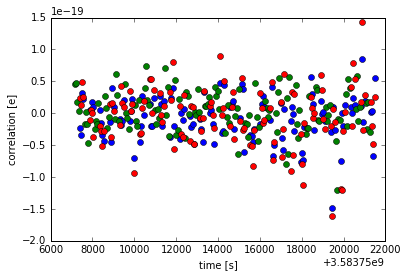

In [15]:
plt.plot(t[8::8],corr[8::8],'bo',label='normal')
plt.plot(t[9::8],corr[9::8],'bo')
plt.plot(t[10::8],corr[10::8],'bo')
plt.plot(t[11::8],corr[11::8],'bo')

plt.plot(t[4::8],corr[4::8],'go',label='diagonal')
plt.plot(t[5::8],corr[5::8],'go')
plt.plot(t[6::8],corr[6::8],'go')
plt.plot(t[7::8],corr[7::8],'go')

plt.plot(t[8::8],np.array(corr[8::8])+np.array(corr[4::8]),'ro',label='sum')
plt.plot(t[9::8],np.array(corr[9::8])+np.array(corr[5::8]),'ro')
plt.plot(t[10::8],np.array(corr[10::8])+np.array(corr[6::8]),'ro')
plt.plot(t[11::8],np.array(corr[11::8])+np.array(corr[7::8]),'ro')

plt.xlabel('time [s]')
plt.ylabel('correlation [e]')
plt.show()

In [32]:
a = np.array(corr[8::8])+np.array(corr[4::8])
b = np.array(corr[9::8])+np.array(corr[5::8])
c = np.array(corr[10::8])+np.array(corr[6::8])
d = np.array(corr[11::8])+np.array(corr[7::8])
dc_corr_list = np.concatenate((a,b,c,d))

e = t[8::8]
f = t[9::8]
g = t[10::8]
h = t[11::8]
time_steps = np.concatenate((e,f,g,h)) - t[8]

time_steps, dc_corr_list = zip(*sorted(zip(time_steps, dc_corr_list)))

In [33]:
%matplotlib notebook

# plot the figure
pn, binp = np.histogram(dc_corr_list, bins=50)
mup, stdp = norm.fit(dc_corr_list)

mp = float(max(pn))

if mup > 0:
    lboundp = [0.1*mp, 0.1*mup, 0.1*stdp]
    uboundp = [1.2*mp, 1.2*mup, 1.2*stdp]
else:
    lboundp = [0.1*mp, 1.2*mup, 0.1*stdp]
    uboundp = [1.2*mp, 0.1*mup, 1.2*stdp]

x = sorted(list(set(np.concatenate((binp, binn)))))
p = norm.pdf(x, mup, stdp)

xp = (binp[1:] + binp[:-1]) / 2.

poptp, pcovp = curve_fit(corrsteps.gaussian_distribution, xp, pn, bounds=(lboundp, uboundp))
perrp = np.sqrt(np.diag(pcovp))
fitted_data_p = corrsteps.gaussian_distribution(xp, *poptp)

In [35]:
fit_mean = '%.2E' % poptp[1]

In [36]:
fit_mean

'-7.95E-22'

In [37]:
if "E" in fit_mean:
    base, exponent = fit_mean.split("E")
    print base, exponent

-7.95 -22


In [43]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

Units on the legend. instead os \mu, use [e]

x axis is just electron charge, remove the correlation

position the legend on the same side

say how long it took in each plot

<IPython.core.display.Javascript object>


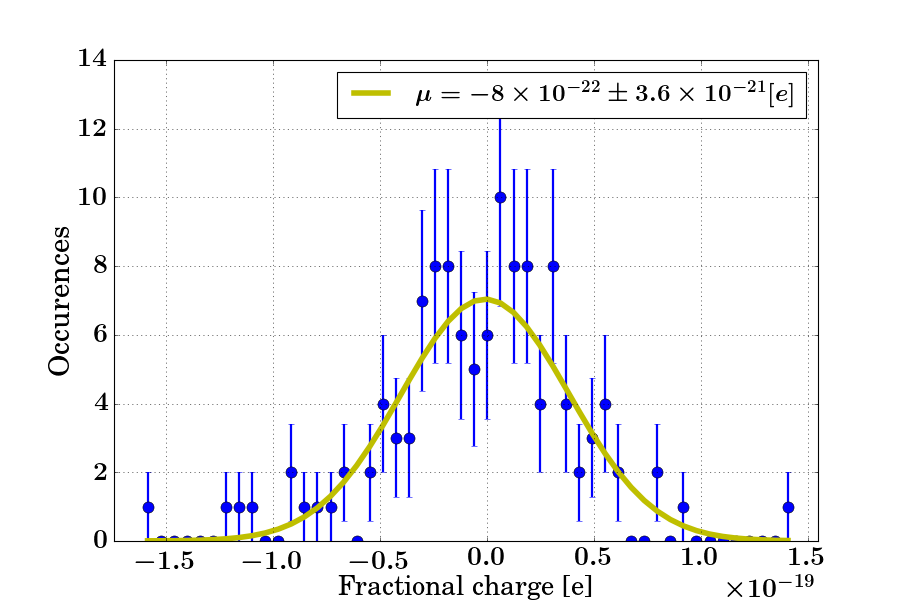

In [63]:
import matplotlib
%matplotlib notebook

plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

fit_mean = latex_float(poptp[1])
fit_std_float = float(poptp[2])/np.sqrt(len(t)/2)
fit_std = latex_float(fit_std_float)
fit_label = '\mu = '+fit_mean+'\pm'+fit_std+' [e]'

plt.errorbar(xp, pn, yerr=np.sqrt(pn), fmt='o', markersize=10, linewidth=2)
plt.plot(xp, fitted_data_p, 'y', linewidth=5, label=fit_label)

# 12200 seconds integration time

plt.xlim([1.1*xp[0],1.1*xp[-1]])
plt.xlabel('Fractional charge [e]')
plt.ylabel('Occurences', size=26)
plt.legend(prop={'size': 22})

plt.grid()
plt.show()

In [25]:
# print parameters
print 'fitting pos to gaussian gives:'
print '           mean = ', poptp[1], ' with error ', perrp[1]
print '    actual mean = ', mup
print ''
print '           standard deviation = ', poptp[2], ' with error ', perrp[2]
print '    actual standard deviation = ', stdp
print ''
print ''
print 'fitting neg to gaussian gives:'
print '           mean = ', poptn[1], ' with error ', perrn[1]
print '    actual mean = ', mun
print ''
print '           standard deviation = ', poptn[2], ' with error ', perrn[2]
print '    actual standard deviation = ', stdn

fitting pos to gaussian gives:
           mean =  -7.95207709776e-22  with error  2.84102499919e-21
    actual mean =  -4.17426885678e-21

           standard deviation =  3.93053438311e-20  with error  1.99586109821e-21
    actual standard deviation =  4.48439868637e-20


fitting neg to gaussian gives:
           mean =  -7.95207709776e-22  with error  2.84102499919e-21
    actual mean =  -4.17426885678e-21

           standard deviation =  3.93053438311e-20  with error  1.99586109821e-21
    actual standard deviation =  4.48439868637e-20
